# Solución al Caso Práctico de Visión Artificial: Detección de Deforestación

Este cuaderno contiene la implementación paso a paso para la detección y cuantificación de áreas deforestadas en imágenes satelitales del Bosque Nacional Jamanxim.

## 1. Configuración e Importación de Librerías

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Configuración para mostrar gráficos en el notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [54]:
# Constantes de escala
PIXELS_REF = 51
KM_REF = 20
AREA_PER_PIXEL = (KM_REF / PIXELS_REF) ** 2
print(f"Área por píxel: {AREA_PER_PIXEL:.4f} km²")

Área por píxel: 0.1538 km²


## 2. Carga y Exploración de Datos

Definimos la ruta de las imágenes extraídas y cargamos la secuencia temporal.

Se encontraron 20 imágenes.


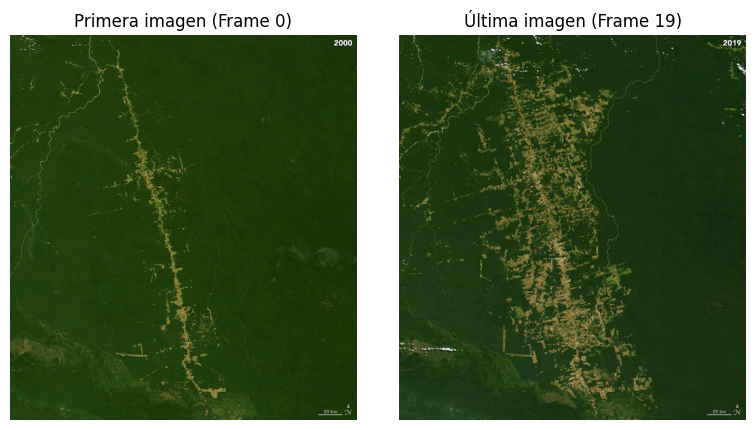

In [55]:
input_dir = r"extracted_frames"
image_files = sorted(glob.glob(os.path.join(input_dir, "*.png")))

print(f"Se encontraron {len(image_files)} imágenes.")

if image_files:
    # Leer primera imagen
    img_first = cv2.imread(image_files[0])
    img_first_rgb = cv2.cvtColor(img_first, cv2.COLOR_BGR2RGB)

    # Leer última imagen
    img_last = cv2.imread(image_files[-1])
    img_last_rgb = cv2.cvtColor(img_last, cv2.COLOR_BGR2RGB)

    # Crear subplots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_first_rgb)
    plt.title("Primera imagen (Frame 0)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_last_rgb)
    plt.title(f"Última imagen (Frame {len(image_files)-1})")
    plt.axis("off")

    plt.subplots_adjust(wspace=0.01)
    plt.savefig("out/evolucion_frames.png", dpi=300)

    plt.show()

In [66]:
def select_random_seeds(image, margin_percent, dark_mask, num_seeds=10, seed=None):

    h, w = image.shape[:2]

    # Márgenes
    margin_y = int(margin_percent * h)
    margin_x = int(margin_percent * w)

    y_min, y_max = margin_y, h - margin_y
    x_min, x_max = margin_x, w - margin_x

    # Región central (a excluir)
    central_mask = np.zeros(dark_mask.shape, dtype=bool)
    central_mask[y_min:y_max, x_min:x_max] = True

    # Oscuros fuera del margen central
    valid_mask = dark_mask & ~central_mask

    # División izquierda / derecha
    mid_x = w // 2

    left_mask  = valid_mask & (np.arange(w)[None, :] < mid_x)
    right_mask = valid_mask & (np.arange(w)[None, :] >= mid_x)

    ys_l, xs_l = np.where(left_mask)
    ys_r, xs_r = np.where(right_mask)

    if len(xs_l) == 0 and len(xs_r) == 0:
        return []

    np.random.seed(seed)

    n_left  = num_seeds // 2
    n_right = num_seeds - n_left

    seeds = []

    if len(xs_l) > 0:
        idx_l = np.random.choice(len(xs_l),
                                 size=min(n_left, len(xs_l)),
                                 replace=False)
        seeds.extend(zip(ys_l[idx_l], xs_l[idx_l]))

    if len(xs_r) > 0:
        idx_r = np.random.choice(len(xs_r),
                                 size=min(n_right, len(xs_r)),
                                 replace=False)
        seeds.extend(zip(ys_r[idx_r], xs_r[idx_r]))

    return seeds


In [67]:
def plot_intensity_analysis(image, title_prefix, margin_percent=0.2, percentile_bright=98, percentile_dark=30, num_seeds= 10, seed=42):
    """Grafica: Original | Grises | Histograma Intensidad | Máscara Brillo (>percentile_bright99)."""

    h, w = image.shape[:2]

    margin_y = int(margin_percent * h)
    margin_x = int(margin_percent * w)

    y_min, y_max = margin_y, h - margin_y
    x_min, x_max = margin_x, w - margin_x

    img_vis = image.copy()
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = np.percentile(gray, percentile_bright)
    bright_mask = gray >= threshold

    threshold2 = np.percentile(gray, percentile_dark)
    dark_mask = gray <= threshold2
    # kernel = np.ones((3,3), np.uint8)
    # bright_mask_clean = cv2.morphologyEx(bright_mask.astype(np.uint8),
    #                                      cv2.MORPH_OPEN,
    #                                      kernel)
    print(
    f"Alto {h} por ancho {w} de la imagen = {h * w} pixeles\n",    
    f"p{percentile_bright} = {threshold:.1f}\n",
    f"Area de pixeles brillosos: {np.count_nonzero(bright_mask) * AREA_PER_PIXEL :.3f} Km2"
    )

    plt.figure(figsize=(20, 5))
    
    # 1. Imagen Original (Convertir BGR a RGB para matplotlib)
    plt.subplot(1, 5, 1)
    plt.imshow(img_vis)
    plt.title(f"{title_prefix} - Original")
    plt.axis('off')
    
    # 2. Escala de Grises
    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Escala de Grises")
    plt.axis('off')

    # 3. Histograma de Intensidades
    plt.subplot(1, 5, 3)
    plt.hist(gray.ravel(), bins=256, color='gray')
    plt.axvline(threshold, color='r', linestyle='--', label=f'p{percentile_bright}: {threshold:.1f}')
    plt.title("Histograma de Intensidad")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Máscara de Alta Intensidad
    plt.subplot(1, 5, 4)
    plt.imshow(bright_mask, cmap='gray')
    plt.title("Máscara de Alta Intensidad")
    plt.axis('off')

    # 5. Seleccion aleatoria de semillas
    seeds = select_random_seeds(gray, margin_percent, dark_mask, num_seeds, seed)
    # Dibujar ROI Region central
    cv2.rectangle(img_vis,
                (x_min, y_min),
                (x_max, y_max),
                (255, 255, 0), 2)

    # Dibujar semillas
    for y, x in seeds:
        cv2.circle(img_vis, (x, y), 3, (255, 0, 0), -1)
    
    plt.subplot(1, 5, 5)
    plt.imshow(img_vis, cmap='gray')
    plt.title(f"Selección Aleatoria de {num_seeds} semillas")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Alto 800 por ancho 720 de la imagen = 576000 pixeles
 p98.1 = 90.0
 Area de pixeles brillosos: 1710.573 Km2


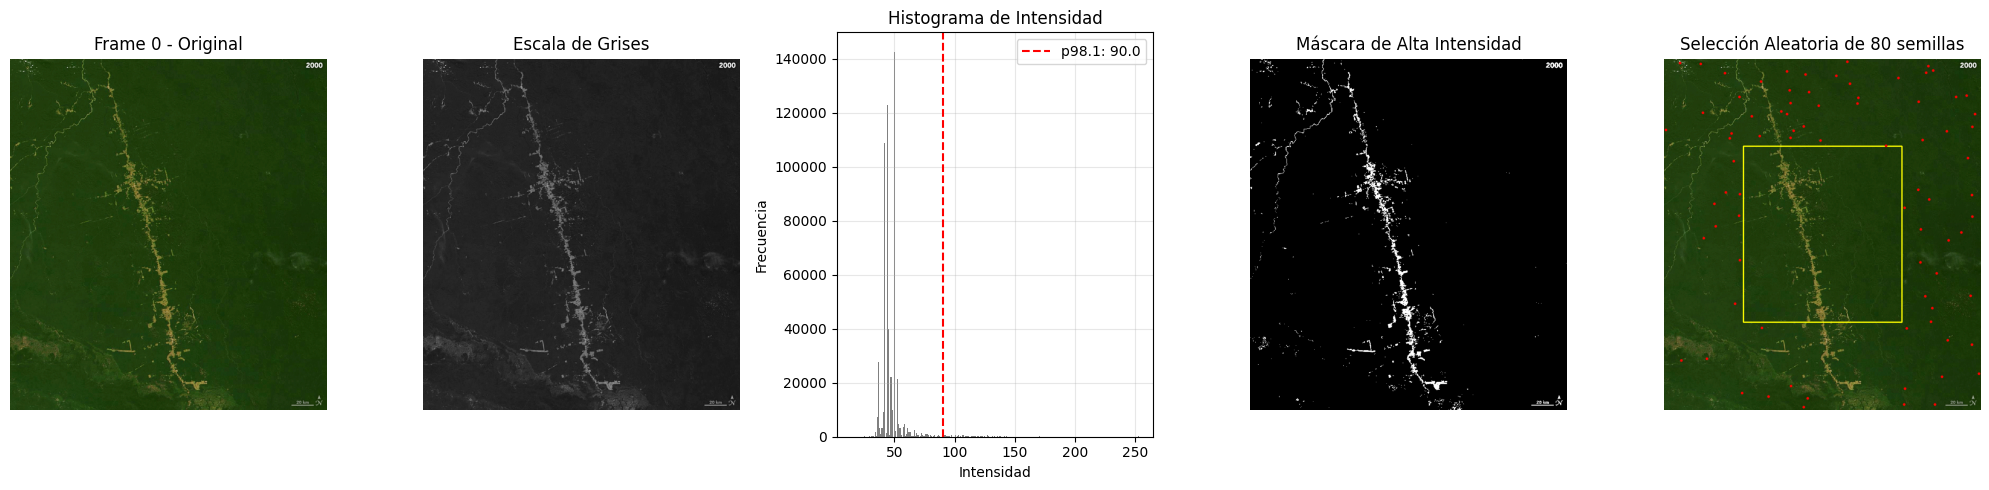

Alto 800 por ancho 720 de la imagen = 576000 pixeles
 p91 = 81.0
 Area de pixeles brillosos: 8026.759 Km2


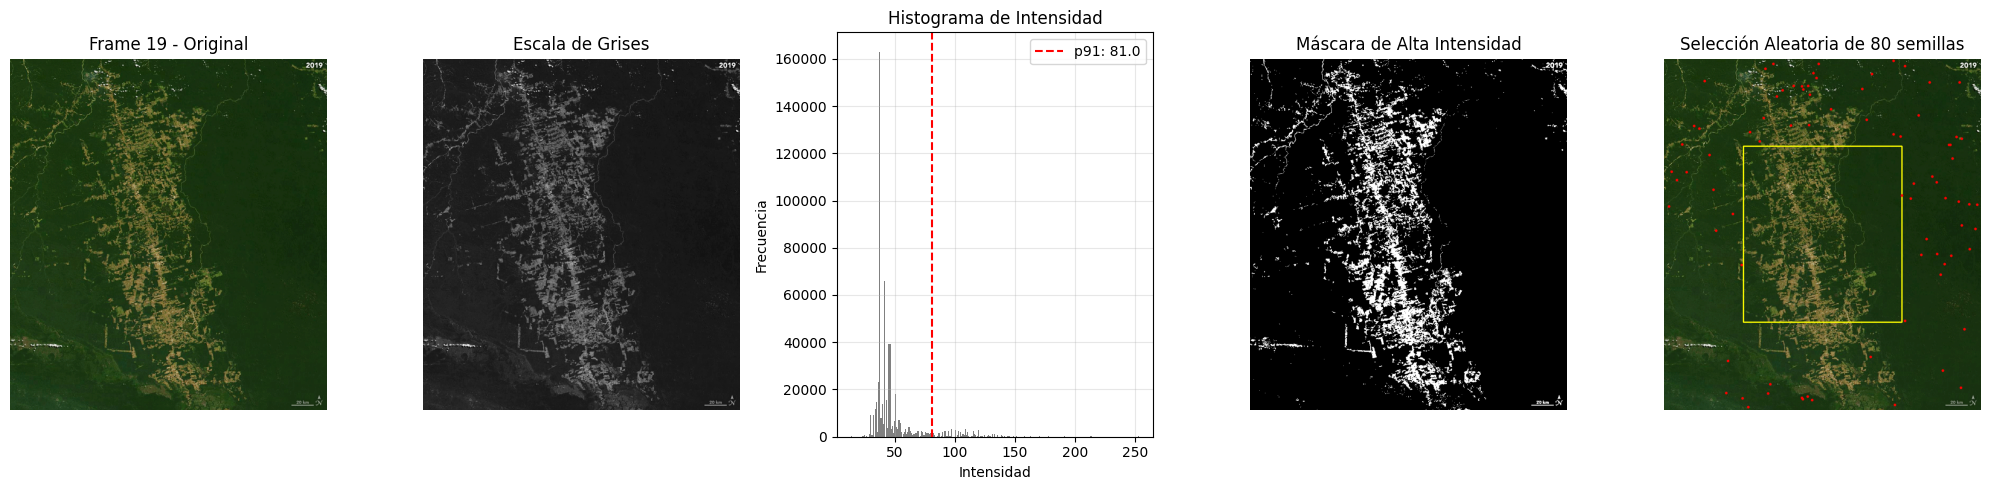

In [75]:
# Índices de los frames a analizar
frame_indices = [0, 19]

for idx in frame_indices:
    if idx < len(image_files):
        img_path = image_files[idx]
        img = cv2.imread(img_path)
        
        if img is not None:
            if idx == 0:
                plot_intensity_analysis(image=img, title_prefix=f"Frame {idx}", margin_percent=0.25,
                                        percentile_bright=98.1, num_seeds=80, seed=30)
            else:
                plot_intensity_analysis(image=img, title_prefix=f"Frame {idx}", margin_percent=0.25,
                                        percentile_bright=91, num_seeds=80, seed=30)
        else:
            print(f"Error al cargar frame {idx}")

## 3. Implementación de Algoritmos

Se implementan funciones para:
1.  **Preprocesamiento**: Mejora de contraste (CLAHE).
2.  **Segmentación por Umbral (Otsu)**.
3.  **Segmentación por Color (HSV/Lab)**.
4.  **Post-procesamiento**: Operaciones morfológicas.

In [69]:
def preprocess_image(image):
    """
    Aplica conversión a escala de grises y mejora de contraste (CLAHE).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    # Suavizado para reducir ruido
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    return blurred

def segment_otsu(image):
    """
    Segmentación basada en umbralización de Otsu.
    """
    processed = preprocess_image(image)
    # Otsu invierte si el objeto es oscuro sobre fondo claro, ajustamos según necesidad
    # Asumimos que la deforestación (tierra) es más clara o distinta del bosque oscuro
    ret, mask = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def segment_color_hsv(image):
    """
    Segmentación basada en color HSV para aislar zonas no verdes (tierra/deforestado).
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Definir rango para color verde (bosque)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    
    # Máscara de bosque
    mask_forest = cv2.inRange(hsv, lower_green, upper_green)
    
    # Invertir para obtener lo que NO es bosque (deforestación)
    mask_deforestation = cv2.bitwise_not(mask_forest)
    return mask_deforestation

def post_process_morphology(mask):
    """
    Aplica operaciones morfológicas para limpiar la máscara.
    """
    kernel = np.ones((5,5), np.uint8)
    # Opening para quitar ruido blanco (pequeños puntos)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Closing para cerrar agujeros dentro de las zonas detectadas
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing

In [ ]:
from collections import deque

def segment_region_growing_forest(
    img,
    percentile=25,
    num_seeds=50,
    tolerance=18,     # más estricto
    margin_percent=0.25
):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape

    # 1️⃣ Máscara de oscuros
    threshold = np.percentile(gray, percentile)
    dark_mask = gray <= threshold

    # 2️⃣ Semillas estratificadas
    seeds = select_random_seeds(
        gray,
        margin_percent,
        dark_mask,
        num_seeds,
        seed=30
    )

    if len(seeds) == 0:
        return np.zeros_like(gray, dtype=np.uint8)

    segmentation = np.zeros_like(gray, dtype=np.uint8)
    processed = np.zeros_like(gray, dtype=bool)

    # 3️⃣ Region growing por seed (NO global)
    for sy, sx in seeds:

        if processed[sy, sx]:
            continue

        queue = deque([(sy, sx)])
        region_mean = float(gray[sy, sx])

        processed[sy, sx] = True
        segmentation[sy, sx] = 255

        while queue:
            y, x = queue.popleft()

            for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
                ny, nx = y + dy, x + dx

                if 0 <= ny < rows and 0 <= nx < cols and not processed[ny, nx]:
                    diff = abs(float(gray[ny, nx]) - region_mean)

                    if diff < tolerance:
                        processed[ny, nx] = True
                        segmentation[ny, nx] = 255
                        queue.append((ny, nx))

                        # actualización lenta del promedio
                        region_mean = 0.99 * region_mean + 0.01 * gray[ny, nx]

    return segmentation

In [71]:
# --- Funciones de Segmentación Adicionales ---

def segment_split_merge_approx(img):
    # Mean Shift como aproximación
    return cv2.pyrMeanShiftFiltering(img, 20, 40, 1)

def segment_kmeans(img, k=4):
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Heurística: Identificar clusters que NO son verdes (deforestación)
    # Convertir centros a HSV para comprobar verde
    centers_hsv = cv2.cvtColor(np.uint8([centers]), cv2.COLOR_BGR2HSV)[0]
    
    # Rango verde (mismo que segment_color_hsv)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    
    deforested_labels = []
    for i, center_hsv in enumerate(centers_hsv):
        # Si NO está en el rango verde, es deforestado
        if not (np.all(center_hsv >= lower_green) and np.all(center_hsv <= upper_green)):
            deforested_labels.append(i)
            
    # Crear máscara
    mask = np.isin(labels.flatten(), deforested_labels).reshape(img.shape[:2])
    return (mask.astype(np.uint8) * 255)

def segment_slic(img, n_segments=200):
    try:
        from skimage.segmentation import slic
        from skimage.util import img_as_float
        
        # SLIC
        segments = slic(img_as_float(img), n_segments=n_segments, compactness=10, sigma=1, start_label=0)
        
        # Clasificar segmentos como deforestación si su color medio no es verde
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        
        # Convertir imagen a HSV para análisis de color
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])
        
        for seg_idx in np.unique(segments):
            # Máscara del segmento actual
            seg_mask = (segments == seg_idx)
            
            # Color medio en HSV
            mean_color = cv2.mean(hsv_img, mask=seg_mask.astype(np.uint8))[:3]
            
            # Chequear si es verde
            is_green = (lower_green[0] <= mean_color[0] <= upper_green[0]) and (lower_green[1] <= mean_color[1] <= upper_green[1]) and (lower_green[2] <= mean_color[2] <= upper_green[2])
            
            if not is_green:
                mask[seg_mask] = 255
                
        return mask
    except ImportError:
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [72]:
# GrabCut
'''
1. Inicialización por máscara adaptativa
2. Usar intensidad para preclasificar (Oscuro=Bosque, Claro=Deforestación)
3. Segmentar bosque como foreground
4. Invertir para obtener deforestación
5. Suavizar con morfología
'''
def segment_grabcut_forest(img, iterations=5):
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1️⃣ Inicialización: Todo es Probable Foreground (Bosque)
    # Asumimos que la mayor parte es bosque
    grabcut_mask = np.full((h, w), cv2.GC_PR_FGD, np.uint8)

    # 2️⃣ Preclasificación por Intensidad
    # Suelo/Deforestación suele ser más claro que el bosque denso
    
    # Zona clara -> Fondo Seguro (Deforestación)
    p_bright = np.percentile(gray, 95) 
    grabcut_mask[gray > p_bright] = cv2.GC_BGD
    
    # Zona oscura -> Bosque Seguro
    p_dark = np.percentile(gray, 30)
    grabcut_mask[gray < p_dark] = cv2.GC_FGD

    # Nota: Eliminamos la inicialización de bordes fijos ya que puede inducir errores
    # si el bosque toca los bordes.

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    try:
        cv2.grabCut(
            img,
            grabcut_mask,
            None,
            bgdModel,
            fgdModel,
            iterations,
            cv2.GC_INIT_WITH_MASK
        )
    except cv2.error:
        # Fallback si GrabCut falla
        return np.zeros((h,w), dtype=np.uint8)

    # 3️⃣ Extraer Bosque (FGD + PR_FGD)
    forest = np.where(
        (grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD),
        255, 0
    ).astype(np.uint8)
    
    # 4️⃣ Suavizado con Morfología
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    forest = cv2.morphologyEx(forest, cv2.MORPH_OPEN, kernel)
    forest = cv2.morphologyEx(forest, cv2.MORPH_CLOSE, kernel)

    # 5️⃣ Invertir para retornar Deforestación
    return cv2.bitwise_not(forest)


## 4. Cuantificación y Análisis Temporal

Calculamos el área deforestada usando la escala proporcionada:
- **51 píxeles = 20 km**
- Factor de escala lineal: $20 / 51$ km/px
- Factor de área: $(20 / 51)^2$ km²/px²

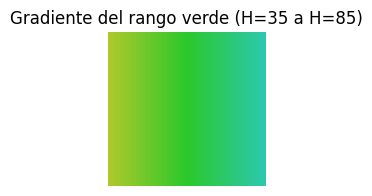

In [73]:
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

h_values = np.arange(lower_green[0], upper_green[0] + 1)
s = 200  # saturación fija
v = 200  # brillo fijo

hsv_strip = np.zeros((50, len(h_values), 3), dtype=np.uint8)

for i, h in enumerate(h_values):
    hsv_strip[:, i] = [h, s, v]

rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(10, 2))
plt.imshow(rgb_strip)
plt.title("Gradiente del rango verde (H=35 a H=85)")
plt.axis("off")
plt.show()

In [35]:
results.pop('GrabCut')
results['GrabCut'] = []

for idx, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    if img is None: continue
    mask_grab = segment_grabcut_forest(
        img,
        iterations=5
    )
    results['GrabCut'].append(cv2.countNonZero(mask_grab) * AREA_PER_PIXEL)
    print(f"Frame {idx}: {cv2.countNonZero(mask_grab) * AREA_PER_PIXEL}")

Frame 0: 30856.74740484429
Frame 1: 18548.404459823145
Frame 2: 43144.944252210684
Frame 3: 30263.437139561705
Frame 4: 28111.03421760861
Frame 5: 25949.096501345633
Frame 6: 23949.096501345633
Frame 7: 43814.99423298731
Frame 8: 46575.7785467128
Frame 9: 28534.87120338331
Frame 10: 21799.7693194925
Frame 11: 17732.564398308343
Frame 12: 20390.157631680122
Frame 13: 19735.486351403306
Frame 14: 25518.185313341022
Frame 15: 25834.98654363706
Frame 16: 18244.67512495194
Frame 17: 25039.13879277201
Frame 18: 23681.045751633985
Frame 19: 22235.294117647056


In [74]:
# Inicializar listas de resultados
results = {
    'Otsu': [],
    'Color (HSV)': [],
    'Region Growing': [],
    'K-Means': [],
    'SLIC': [],
    'GrabCut': [],
    'Watershed': [],
    'Motion (MOG2)': []
}

In [79]:
for idx, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    if img is None: continue
    forest_mask = segment_region_growing_forest(
        img,
        percentile=30,
        num_seeds=80,
        tolerance=30
    )

    deforestation_mask = cv2.bitwise_not(forest_mask)
    area_def = cv2.countNonZero(deforestation_mask) * AREA_PER_PIXEL
    results['Region Growing'].append(area_def)

In [80]:
results['Region Growing']

[9795.770857362551,
 2233.910034602076,
 1997.8469819300267,
 3059.284890426759,
 2406.151480199923,
 4230.219146482122,
 3597.693194925029,
 4359.861591695501,
 5515.570934256055,
 6380.6228373702415,
 6479.046520569012,
 5992.925797770088,
 6688.350634371395,
 6632.525951557093,
 6436.75509419454,
 9613.687043444828,
 5103.575547866205,
 8737.408688965781,
 10148.865820838138,
 8516.416762783545,
 9795.770857362551]

In [ ]:
years = list(range(2000, 2000 + len(image_files))) 

# Inicializar Motion Subtractor
backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

print("Procesando imágenes...")

for idx, img_path in enumerate(image_files):
    img = cv2.imread(img_path)
    if img is None: continue
    
    # --- Métodos Existentes ---
    # Otsu
    mask_otsu = segment_otsu(img)
    mask_otsu_clean = post_process_morphology(mask_otsu)
    results['Otsu'].append(cv2.countNonZero(mask_otsu_clean) * AREA_PER_PIXEL)
    
    # Color
    mask_color = segment_color_hsv(img)
    mask_color_clean = post_process_morphology(mask_color)
    results['Color (HSV)'].append(cv2.countNonZero(mask_color_clean) * AREA_PER_PIXEL)
    
    # --- Nuevos Métodos ---
    # Region Growing
    try:
        forest_mask = segment_region_growing_forest(
            img,
            percentile=30,
            num_seeds=80,
            tolerance=30
        )

        deforestation_mask = cv2.bitwise_not(forest_mask)
        area_def = cv2.countNonZero(deforestation_mask) * AREA_PER_PIXEL
        results['Region Growing'].append(area_def)
    except: results['Region Growing'].append(0)
        
    # K-Means
    try:
        mask_kmeans = segment_kmeans(img)
        results['K-Means'].append(cv2.countNonZero(mask_kmeans) * AREA_PER_PIXEL)
    except: results['K-Means'].append(0)
        
    # SLIC
    try:
        mask_slic = segment_slic(img)
        results['SLIC'].append(cv2.countNonZero(mask_slic) * AREA_PER_PIXEL)
    except: results['SLIC'].append(0)
        
    # GrabCut
    try:
        mask_grab = segment_grabcut_forest(
            img,
            percentile=30,
            iterations=5
        )
        results['GrabCut'].append(cv2.countNonZero(mask_grab) * AREA_PER_PIXEL)
    except: results['GrabCut'].append(0)
        
    # Watershed
    try:
        mask_ws = segment_watershed(img)
        results['Watershed'].append(cv2.countNonZero(mask_ws) * AREA_PER_PIXEL)
    except: results['Watershed'].append(0)
        
    # Motion
    fg_mask = backSub.apply(img)
    # Motion mask acumula cambios, tomamos el frame actual
    results['Motion (MOG2)'].append(cv2.countNonZero(fg_mask) * AREA_PER_PIXEL)

    print(f"Procesado año {years[idx]}")

print("Procesamiento completado.")

Procesando imágenes...
Procesado año 2000
Procesado año 2001
Procesado año 2002
Procesado año 2003
Procesado año 2004
Procesado año 2005
Procesado año 2006
Procesado año 2007
Procesado año 2008
Procesado año 2009
Procesado año 2010
Procesado año 2011
Procesado año 2012
Procesado año 2013
Procesado año 2014
Procesado año 2015
Procesado año 2016
Procesado año 2017
Procesado año 2018
Procesado año 2019
Procesamiento completado.


## 5. Visualización de Resultados

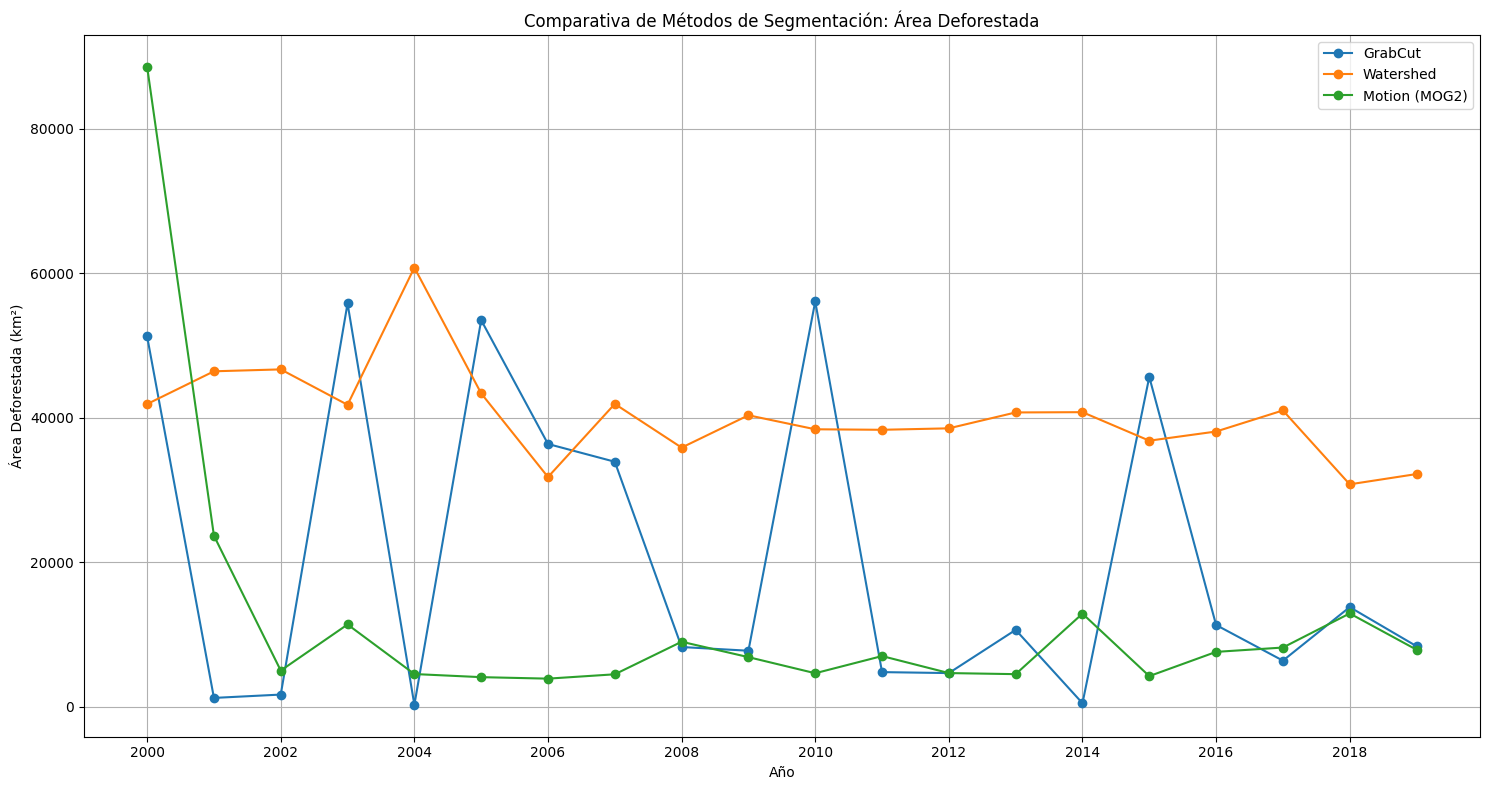

In [98]:
plt.figure(figsize=(15, 8))

# Graficar todos los resultados
for method_name, areas in results.items():

    if method_name in ['Motion (MOG2)', 'GrabCut', 'Watershed']:

        if len(areas) == len(years):
            plt.plot(years, areas, marker='o', label=method_name)

plt.title('Comparativa de Métodos de Segmentación: Área Deforestada')
plt.xlabel('Año')
plt.ylabel('Área Deforestada (km²)')
plt.grid(True)
plt.xticks(np.arange(min(years), max(years) + 1, 2))
plt.legend()
plt.tight_layout()
plt.savefig('out/grafico_comparativo_completo.png')
plt.show()

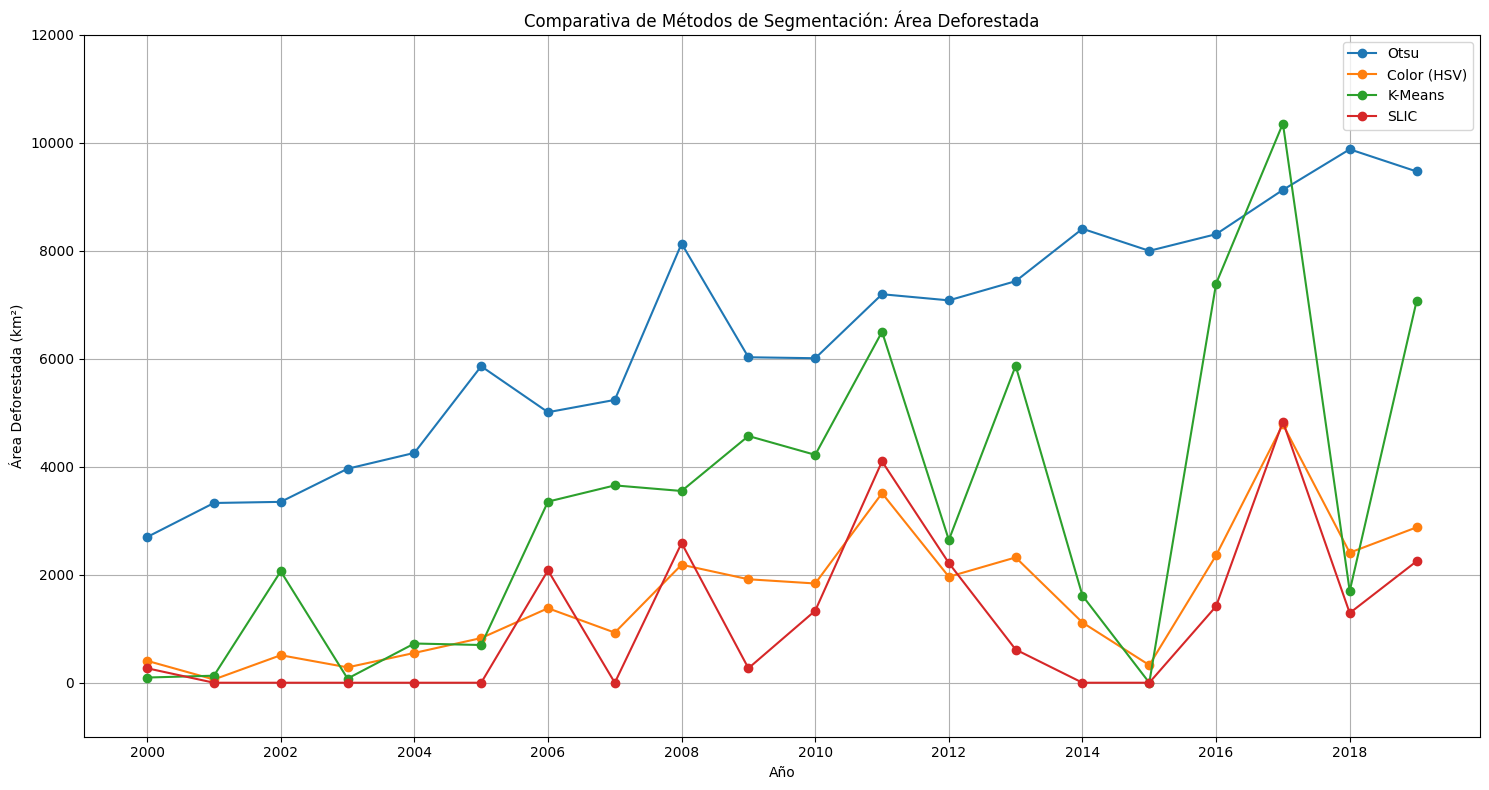

In [97]:
plt.figure(figsize=(15, 8))

# Graficar todos los resultados
for method_name, areas in results.items():

    if method_name not in ['Motion (MOG2)', 'GrabCut', 'Watershed']:

        if len(areas) == len(years):
            plt.plot(years, areas, marker='o', label=method_name)

plt.title('Comparativa de Métodos de Segmentación: Área Deforestada')
plt.xlabel('Año')
plt.ylabel('Área Deforestada (km²)')
plt.grid(True)
plt.xticks(np.arange(min(years), max(years) + 1, 2))
plt.legend()
plt.ylim(-1000,12000)
plt.tight_layout()
plt.savefig('out/grafico_comparativo_completo2.png')
plt.show()

## 6. Análisis de Histogramas (Frames 0 y 19)

Comparación de histogramas RGB entre la imagen original y la región segmentada (deforestación) para el primer y último frame.

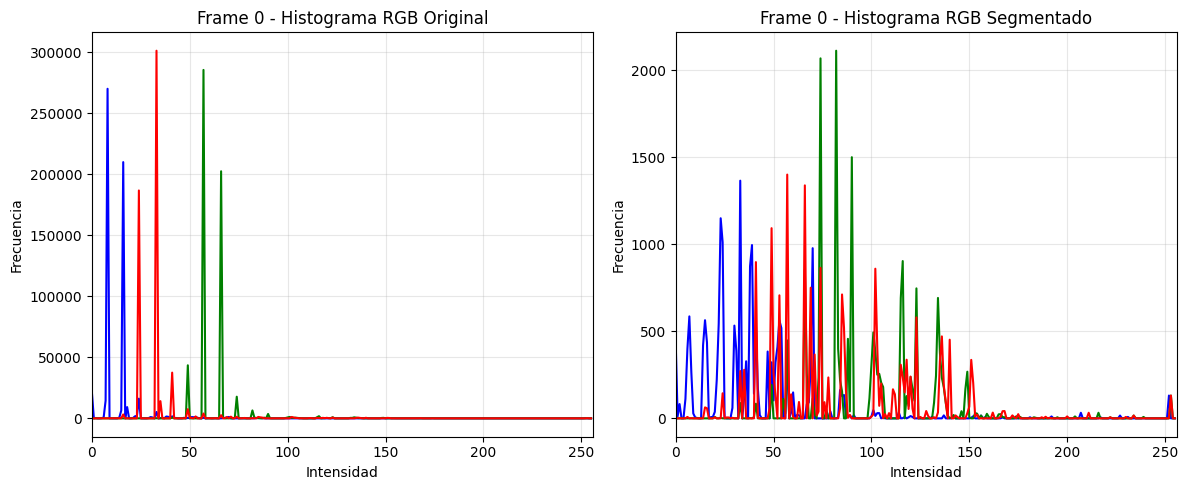

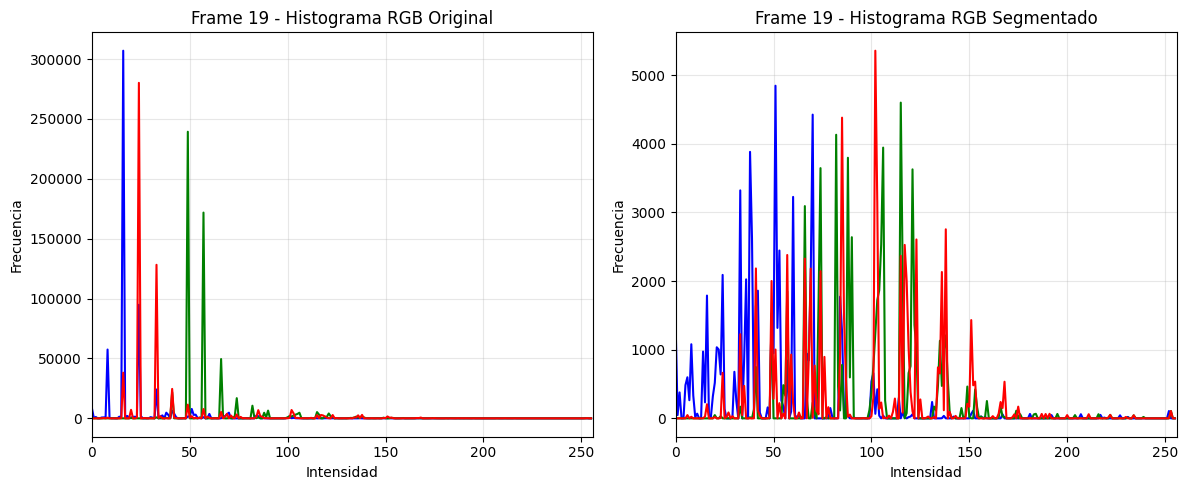

In [15]:
def plot_histogram_comparison(image, mask, title_prefix):
    """Calcula y grafica histogramas RGB para imagen original y segmentada."""
    plt.figure(figsize=(12, 5))
    
    # Histograma Original
    plt.subplot(1, 2, 1)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title(f"{title_prefix} - Histograma RGB Original")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.grid(True, alpha=0.3)

    # Histograma Segmentado (Solo pixeles de la máscara)
    plt.subplot(1, 2, 2)
    for i, color in enumerate(colors):
        # Calcular histograma solo en la región de la máscara (deforestación)
        hist = cv2.calcHist([image], [i], mask, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title(f"{title_prefix} - Histograma RGB Segmentado")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Índices de los frames a analizar
frame_indices = [0, 19]

for idx in frame_indices:
    if idx < len(image_files):
        img_path = image_files[idx]
        img = cv2.imread(img_path)
        
        if img is not None:
            # Usamos Otsu como método principal para el análisis
            mask = segment_otsu(img).astype(np.uint8)
            mask = post_process_morphology(mask)
            
            plot_histogram_comparison(img, mask, f"Frame {idx}")
        else:
            print(f"Error al cargar frame {idx}")


## 7. Análisis de Histogramas HSV (Frames 0 y 19)

Comparación de histogramas en el espacio de color HSV (Matiz y Saturación) para analizar cambios en el color más allá del RGB.

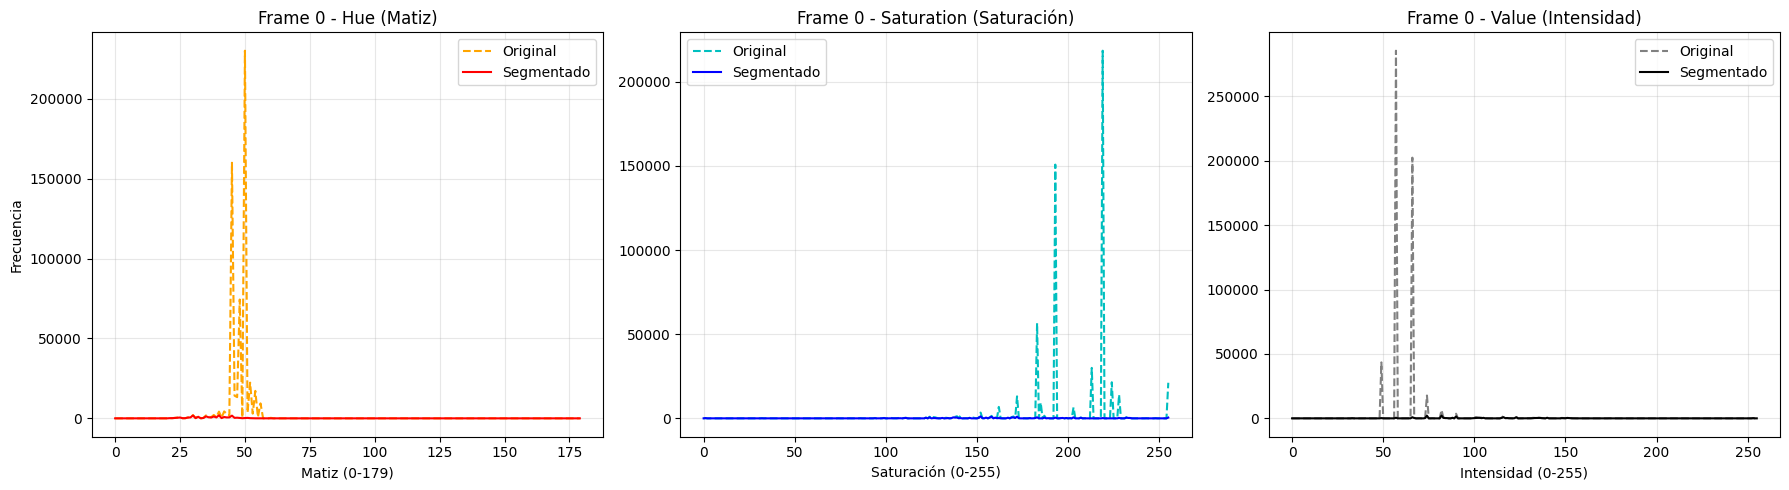

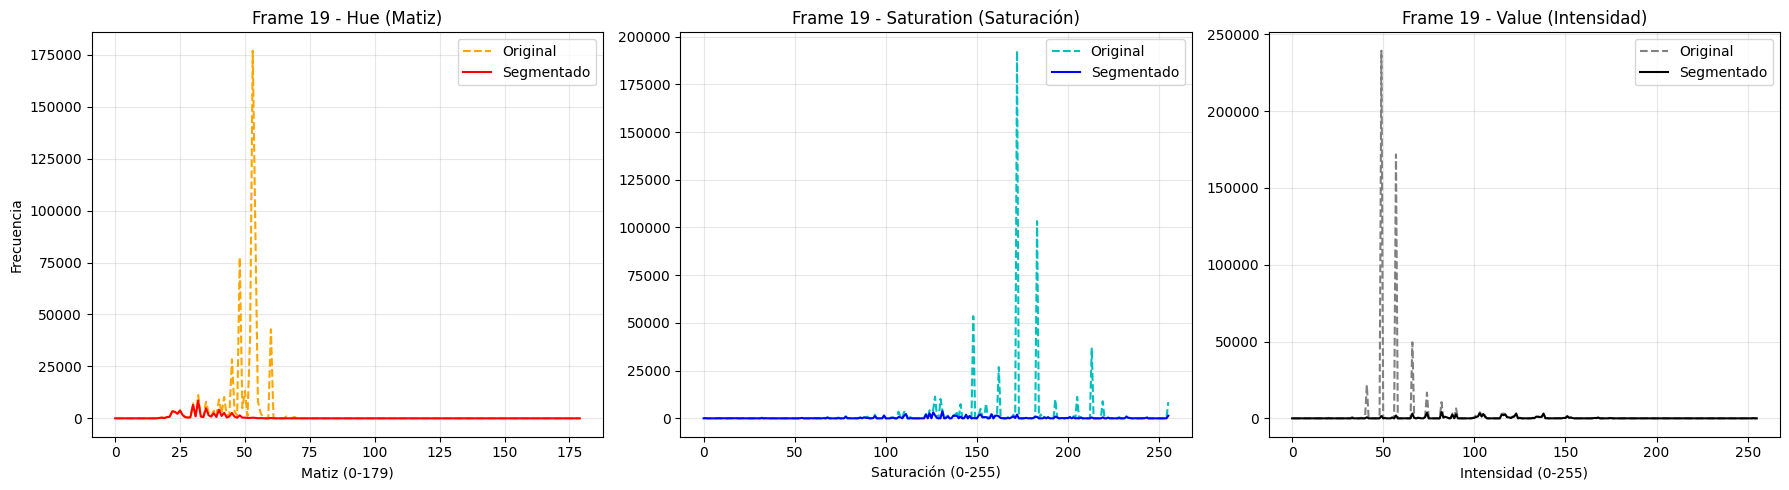

In [16]:
def plot_hsv_histogram_comparison(image, mask, title_prefix):
    """Calcula y grafica histogramas HSV (H, S y V) para imagen original y segmentada."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    plt.figure(figsize=(18, 5))
    
    # Histograma Hue (Matiz)
    plt.subplot(1, 3, 1)
    # Original (completo)
    hist_h_orig = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    plt.plot(hist_h_orig, color='orange', label='Original', linestyle='--')
    # Segmentado (Deforestación)
    hist_h_seg = cv2.calcHist([hsv_image], [0], mask, [180], [0, 180])
    plt.plot(hist_h_seg, color='red', label='Segmentado')
    
    plt.title(f"{title_prefix} - Hue (Matiz)")
    plt.xlabel("Matiz (0-179)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histograma Saturation (Saturación)
    plt.subplot(1, 3, 2)
    # Original (completo)
    hist_s_orig = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    plt.plot(hist_s_orig, color='c', label='Original', linestyle='--')
    # Segmentado (Deforestación)
    hist_s_seg = cv2.calcHist([hsv_image], [1], mask, [256], [0, 256])
    plt.plot(hist_s_seg, color='blue', label='Segmentado')
    
    plt.title(f"{title_prefix} - Saturation (Saturación)")
    plt.xlabel("Saturación (0-255)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histograma Value (Valor/Intensidad)
    plt.subplot(1, 3, 3)
    # Original (completo)
    hist_v_orig = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    plt.plot(hist_v_orig, color='gray', label='Original', linestyle='--')
    # Segmentado (Deforestación)
    hist_v_seg = cv2.calcHist([hsv_image], [2], mask, [256], [0, 256])
    plt.plot(hist_v_seg, color='black', label='Segmentado')
    
    plt.title(f"{title_prefix} - Value (Intensidad)")
    plt.xlabel("Intensidad (0-255)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Índices de los frames a analizar
frame_indices = [0, 19]

for idx in frame_indices:
    if idx < len(image_files):
        img_path = image_files[idx]
        img = cv2.imread(img_path)
        
        if img is not None:
            # Usamos Otsu y morfología para la máscara
            mask = segment_otsu(img).astype(np.uint8)
            mask = post_process_morphology(mask)
            
            plot_hsv_histogram_comparison(img, mask, f"Frame {idx}")
        else:
            print(f"Error al cargar frame {idx}")
